### Project Notes

* Airlines are in trouble and customers are "up for grabs". 

* Which features do I care most about for minimum project result?

    * Correlation of feature to target---how to do this one feature at a time?

* Bias in dataset? more likely to take survey if satisfied/dissatisfied?

    * Do I have an imbalanced data set? ---SLIGHTLY
        * Accuracy versus recall/precision

* Precision or recall?
    * care more about getting dissatisfied customers correct?
    * more expensive to lose a customers
    * customer churn/dissatisfaction
    * how much to lose a customer? 
    * lifetime value of an airline customer
    * Create a business case for losing customer/risk

    * be sure to collect highest number of actually dissastisfied
        * precision: capturing dissatisfied, maximize actually dissatisfied (more scrutinous)
        * recall: make call happy passengers, grab as many dissatisfieds, even if some aren't dissatisfied (don't care about false positive)

    * May just want a model that performs well over threshold

* Will eventually use ROC curve to compare algorithms (make decisions one level removed from model through graph)

In [209]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from scipy.spatial.distance import euclidean as euc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
#from visualize import generate_moons_df, preprocess, plot_boundaries


In [210]:
#adding CSVs and concatting dataframes
df_kaggle1 = pd.read_csv("/Users/Tara8082/GIT/ProjectGIT/Project_3/train.csv", index_col = 'Unnamed: 0')
df_kaggle2 = pd.read_csv("/Users/Tara8082/GIT/ProjectGIT/Project_3/test.csv",  index_col = 'Unnamed: 0')
frames = [df_kaggle1, df_kaggle2]
df = pd.concat(frames)

In [211]:
# NEED TO PUT INTO SQL DATABASE (IMPORT TO DATABASE, USE SQL TO PUT INTO DF

In [212]:
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [213]:
#24 total columns

df.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [214]:
# check for nulls
df.isnull().sum()


id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

In [215]:
df = df.dropna(subset = ['Arrival Delay in Minutes'])      

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129487 entries, 0 to 25975
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129487 non-null  int64  
 1   Gender                             129487 non-null  object 
 2   Customer Type                      129487 non-null  object 
 3   Age                                129487 non-null  int64  
 4   Type of Travel                     129487 non-null  object 
 5   Class                              129487 non-null  object 
 6   Flight Distance                    129487 non-null  int64  
 7   Inflight wifi service              129487 non-null  int64  
 8   Departure/Arrival time convenient  129487 non-null  int64  
 9   Ease of Online booking             129487 non-null  int64  
 10  Gate location                      129487 non-null  int64  
 11  Food and drink                     12948

In [217]:
#129,487 rows
df.shape[0]

129487

In [263]:
df['Age'].describe()

count    129487.000000
mean         39.428761
std          15.117597
min           7.000000
25%          27.000000
50%          40.000000
75%          51.000000
max          85.000000
Name: Age, dtype: float64

In [218]:
# Balance of dataset

# imbalance = arandom oversampler (of minority class)
# should I cut some majority?

balance = df['satisfaction'].value_counts('neutral or dissatisfied')
balance

neutral or dissatisfied    0.565501
satisfied                  0.434499
Name: satisfaction, dtype: float64

## EDA

### Correlations

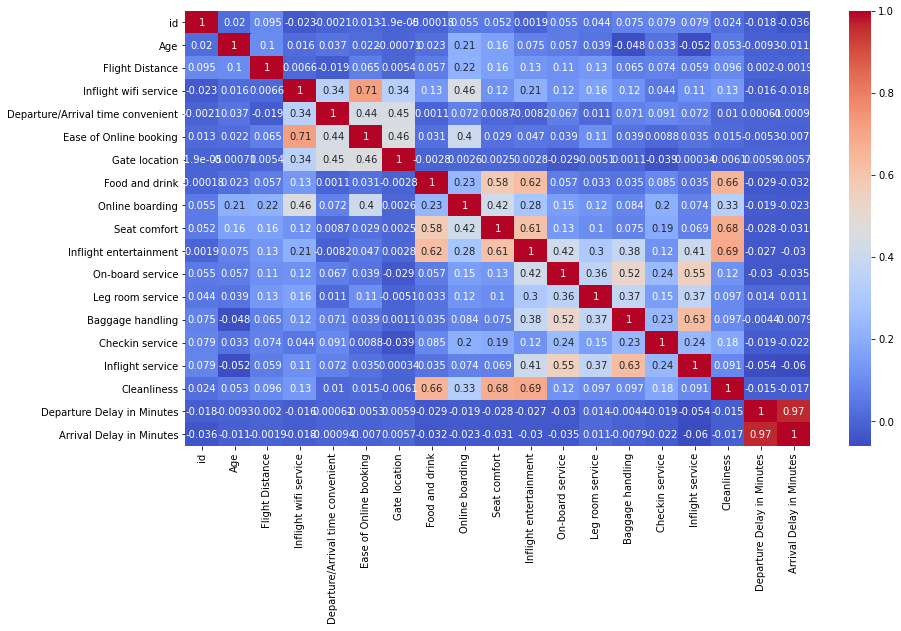

In [219]:
# drop arrival delay in minutes
# some may be highly correlated (high score) but not worth dropping yet until see how model performs

plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), cmap= 'coolwarm', annot=True);

In [220]:
# drop as arrival and departure delay are co-linear

df = df.drop(['Arrival Delay in Minutes'], axis =1 )


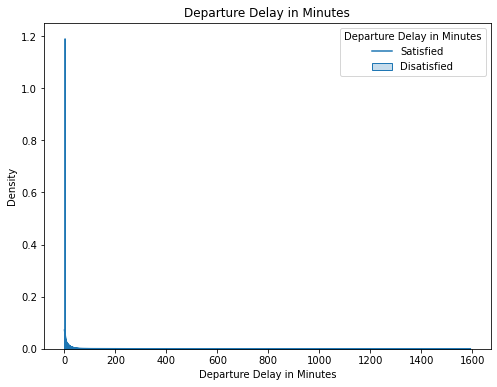

In [156]:
plt.figure(figsize=(8,6))
sns.histplot(x='Departure Delay in Minutes', data=df, alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)
plt.xlabel('Departure Delay in Minutes')
plt.legend(title='Departure Delay in Minutes', loc='upper right', labels=['Satisfied', 'Disatisfied'])
plt.title('Departure Delay in Minutes');

## Modeling

In [264]:
df_model = df.copy()

In [265]:
df_model.head(3)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,5,4,3,4,4,5,5,25,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,1,5,3,1,4,1,1,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,5,4,3,4,4,4,5,0,satisfied


In [266]:
features = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes']

X = df_model[features]
y = df_model['satisfaction'].values



In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=6)

In [249]:
#specify categorical features

categoricals = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
non_cat = ['Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes']

ohe = OneHotEncoder(sparse=False)

cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_train.index) #keep the same index values

#combine continuous and categorical data

X_train_preprocessed = pd.concat([X_train[non_cat], X_train_ohe], axis=1)

#Scale data
ss = StandardScaler()
X_train_preprocessed = ss.fit_transform(X_train_preprocessed)

X_train_preprocessed

array([[-0.79873331,  0.95465944, -1.35099899, ..., -0.95675921,
         1.10665109, -0.2797581 ],
       [ 0.5579254 , -1.30538526,  0.61556318, ...,  1.04519506,
        -0.90362718, -0.2797581 ],
       [-0.50372025,  0.2013112 ,  1.2710839 , ..., -0.95675921,
        -0.90362718,  3.57451672],
       ...,
       [-0.12642463,  0.95465944, -1.35099899, ..., -0.95675921,
        -0.90362718,  3.57451672],
       [-0.12943496,  0.2013112 , -2.00651972, ...,  1.04519506,
        -0.90362718, -0.2797581 ],
       [-1.05160165, -1.30538526,  0.61556318, ..., -0.95675921,
        -0.90362718,  3.57451672]])

In [251]:
# Create validation setwith X_train_preprocessed data

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_preprocessed, y_train, test_size=.3, random_state=2)

In [269]:
#transform and scale testing set

cat_matrix_test = ohe.transform(X_test.loc[:, categoricals]) #remember to only transform on the test set!

X_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_test.index) #keep the same index values

X_test_preprocessed = pd.concat([X_test[non_cat], X_test_ohe], axis=1)

#Scale test data
X_test_preprocessed = ss.transform(X_test_preprocessed)

In [274]:
# Logistic Regression Model

lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

val_preds = lr.predict(X_val_scaled)

#test_preds = lr.predict(X_test_preprocessed)

print(classification_report(y_val, val_preds))

ValueError: Found input variables with inconsistent numbers of samples: [63448, 90640]

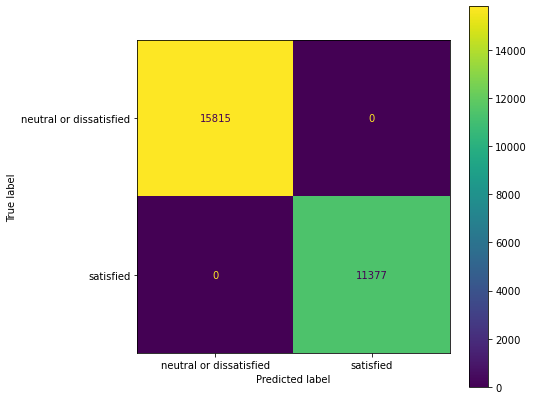

In [261]:
# Confusion Matrix

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_preds, ax=ax);

#### KNN

In [ ]:
#looping through 100 ks

test_scores = []
train_scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, label_train)
    train_score = 100*knn.score(X_train, label_train)
    test_score = 100*knn.score(X_test, label_test)
    test_scores.append(test_score)
    train_scores.append(train_score)

plt.plot(test_scores)
plt.plot(train_scores)